<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/02_hdb_rental_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Clustering HDB Rental Flats

## Objectives:
1. Identify distinct rental market segments
2. Analyze geographical patterns in rental prices
3. Create interactive cluster visualizations
4. Generate insights for different flat types and locations

## Approach:
- K-Means Clustering
- DBSCAN for density-based clustering
- Geographical visualization
- Statistical analysis of clusters

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import folium
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Load and Prepare Data
def load_and_prepare_data():
    # Load data
    df = pd.read_csv('RentingOutofFlats2025.csv')

    # Convert date
    df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date'])

    # Extract room numbers
    def extract_rooms(flat_type):
        if 'EXECUTIVE' in flat_type:
            return 6
        num = ''.join(filter(str.isdigit, flat_type))
        return int(num) if num else 0

    df['rooms'] = df['flat_type'].apply(extract_rooms)

    # Encode categorical variables
    le = LabelEncoder()
    df['town_encoded'] = le.fit_transform(df['town'])

    return df, le

df, town_encoder = load_and_prepare_data()
print("Data Overview:")
print(df.head())

Data Overview:
  rent_approval_date        town block       street_name flat_type  \
0         2021-01-01  ANG MO KIO   105  ANG MO KIO AVE 4    4-ROOM   
1         2021-01-01  ANG MO KIO   107  ANG MO KIO AVE 4    3-ROOM   
2         2021-01-01  ANG MO KIO   108  ANG MO KIO AVE 4    3-ROOM   
3         2021-01-01  ANG MO KIO   111  ANG MO KIO AVE 4    5-ROOM   
4         2021-01-01  ANG MO KIO   111  ANG MO KIO AVE 4    5-ROOM   

   monthly_rent      region  rooms  town_encoded  
0          2000  north-east      4             0  
1          1750  north-east      3             0  
2          1750  north-east      3             0  
3          2230  north-east      5             0  
4          2450  north-east      5             0  


In [3]:
# 3. Feature Engineering for Clustering
def prepare_clustering_features(df):
    # Select features for clustering
    features = ['monthly_rent', 'rooms', 'town_encoded']
    X = df[features].copy()

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, scaler

X_scaled, scaler = prepare_clustering_features(df)

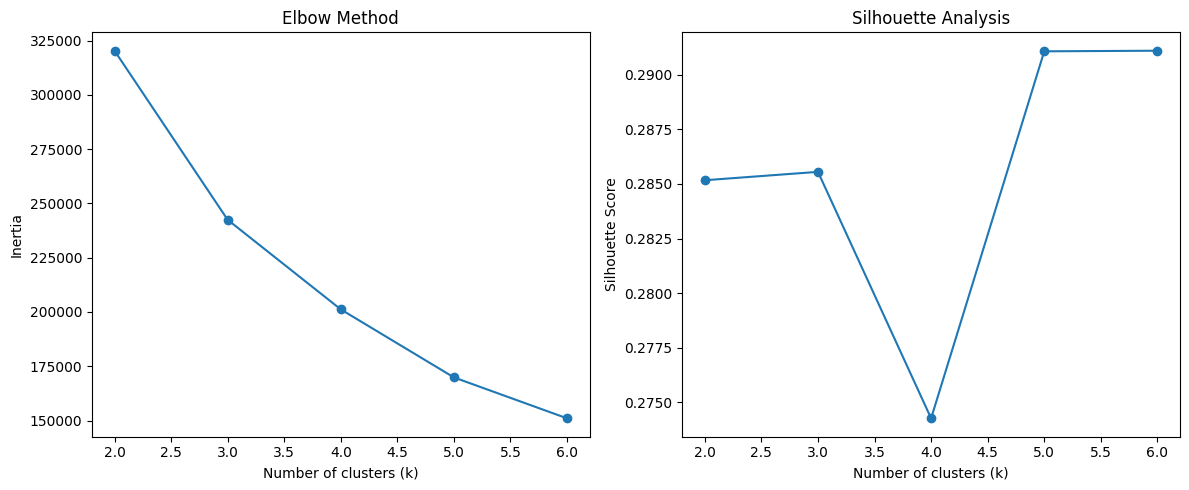

Optimal number of clusters: 6


In [6]:
# 4. Find Optimal Number of Clusters
def find_optimal_clusters(X_scaled, max_clusters=6):
    inertias = []
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    # Plot elbow curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_k

optimal_k = find_optimal_clusters(X_scaled)
print(f"Optimal number of clusters: {optimal_k}")

In [7]:
# 5. Perform Clustering
def perform_clustering(X_scaled, n_clusters):
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    return kmeans_labels, dbscan_labels

kmeans_labels, dbscan_labels = perform_clustering(X_scaled, optimal_k)
df['cluster_kmeans'] = kmeans_labels
df['cluster_dbscan'] = dbscan_labels


Cluster Analysis:
               monthly_rent                rooms  \
                       mean     std  count  mean   
cluster_kmeans                                     
0                   3478.53  547.84  23744  4.31   
1                   3634.99  483.28  17693  5.18   
2                   2284.22  482.33  38805  3.24   
3                   3119.55  377.25  27186  3.69   
4                   2315.52  362.30  20187  5.21   
5                   2010.52  347.79  27849  3.35   

                                             town  
                                         <lambda>  
cluster_kmeans                                     
0               BUKIT MERAH, BEDOK, CHOA CHU KANG  
1                 SENGKANG, JURONG WEST, TAMPINES  
2                  ANG MO KIO, BEDOK, BUKIT MERAH  
3                  TAMPINES, SENGKANG, QUEENSTOWN  
4                JURONG WEST, SENGKANG, WOODLANDS  
5                     YISHUN, TAMPINES, TOA PAYOH  


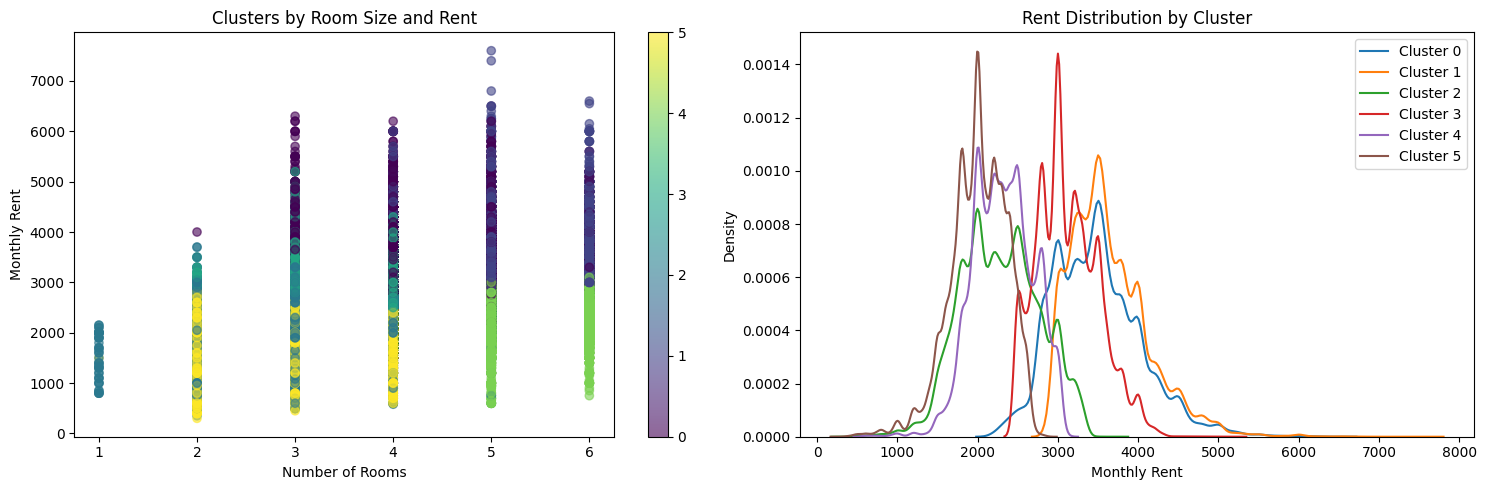

In [8]:
# 6. Analyze Clusters
def analyze_clusters(df):
    # Cluster Statistics
    cluster_stats = df.groupby('cluster_kmeans').agg({
        'monthly_rent': ['mean', 'std', 'count'],
        'rooms': 'mean',
        'town': lambda x: ', '.join(x.value_counts().nlargest(3).index)
    }).round(2)

    print("\nCluster Analysis:")
    print(cluster_stats)

    # Visualize Clusters
    plt.figure(figsize=(15, 5))

    # Plot 1: Rent vs Rooms by Cluster
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(df['rooms'], df['monthly_rent'],
                         c=df['cluster_kmeans'], cmap='viridis', alpha=0.6)
    plt.xlabel('Number of Rooms')
    plt.ylabel('Monthly Rent')
    plt.title('Clusters by Room Size and Rent')
    plt.colorbar(scatter)

    # Plot 2: Distribution of Rent by Cluster
    plt.subplot(1, 2, 2)
    for i in range(optimal_k):
        sns.kdeplot(data=df[df['cluster_kmeans'] == i]['monthly_rent'],
                    label=f'Cluster {i}')
    plt.xlabel('Monthly Rent')
    plt.ylabel('Density')
    plt.title('Rent Distribution by Cluster')
    plt.legend()

    plt.tight_layout()
    plt.show()

analyze_clusters(df)

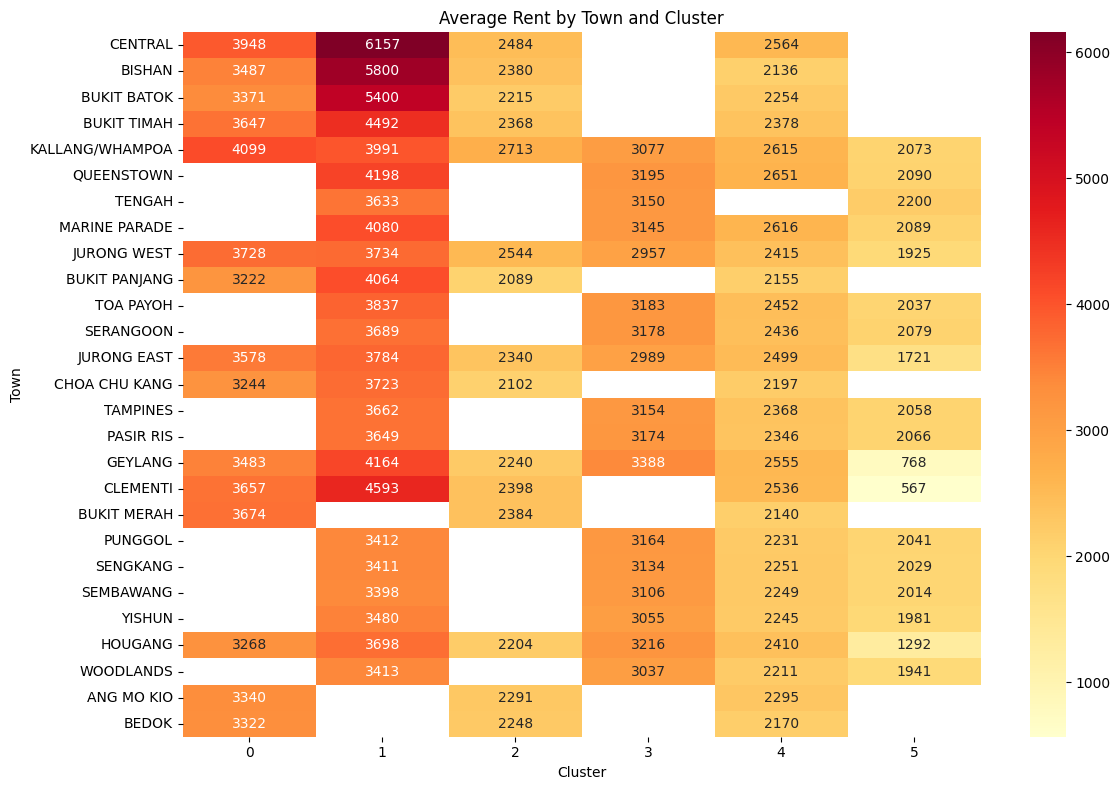

In [9]:
# 7. Market Segment Analysis
def analyze_market_segments(df):
    # Calculate average rent by town and cluster
    town_cluster_stats = df.pivot_table(
        values='monthly_rent',
        index='town',
        columns='cluster_kmeans',
        aggfunc='mean'
    ).round(2)

    # Sort towns by overall average rent
    town_cluster_stats['avg_rent'] = town_cluster_stats.mean(axis=1)
    town_cluster_stats = town_cluster_stats.sort_values('avg_rent', ascending=False)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(town_cluster_stats.drop('avg_rent', axis=1),
                annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Average Rent by Town and Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Town')
    plt.tight_layout()
    plt.show()

    return town_cluster_stats

market_segments = analyze_market_segments(df)

In [10]:
# 8. Generate Insights Report
def generate_insights(df, market_segments):
    print("=== HDB Rental Market Insights ===\n")

    # 1. Overall Market Statistics
    print("1. Overall Market Statistics:")
    print(f"Average Rental Price: ${df['monthly_rent'].mean():.2f}")
    print(f"Median Rental Price: ${df['monthly_rent'].median():.2f}")
    print(f"Price Range: ${df['monthly_rent'].min():.2f} - ${df['monthly_rent'].max():.2f}\n")

    # 2. Cluster Characteristics
    print("2. Cluster Characteristics:")
    for cluster in range(optimal_k):
        cluster_data = df[df['cluster_kmeans'] == cluster]
        print(f"\nCluster {cluster}:")
        print(f"- Average Rent: ${cluster_data['monthly_rent'].mean():.2f}")
        print(f"- Most Common Room Types: {', '.join(cluster_data['flat_type'].value_counts().nlargest(2).index)}")
        print(f"- Top Towns: {', '.join(cluster_data['town'].value_counts().nlargest(3).index)}")

    # 3. Premium and Budget Areas
    print("\n3. Market Segments:")
    print("Premium Areas (Top 3):")
    print(market_segments['avg_rent'].head(3))
    print("\nBudget Areas (Top 3):")
    print(market_segments['avg_rent'].tail(3))

generate_insights(df, market_segments)

=== HDB Rental Market Insights ===

1. Overall Market Statistics:
Average Rental Price: $2721.46
Median Rental Price: $2700.00
Price Range: $300.00 - $7600.00

2. Cluster Characteristics:

Cluster 0:
- Average Rent: $3478.53
- Most Common Room Types: 4-ROOM, 5-ROOM
- Top Towns: BUKIT MERAH, BEDOK, CHOA CHU KANG

Cluster 1:
- Average Rent: $3634.99
- Most Common Room Types: 5-ROOM, EXECUTIVE
- Top Towns: SENGKANG, JURONG WEST, TAMPINES

Cluster 2:
- Average Rent: $2284.22
- Most Common Room Types: 3-ROOM, 4-ROOM
- Top Towns: ANG MO KIO, BEDOK, BUKIT MERAH

Cluster 3:
- Average Rent: $3119.55
- Most Common Room Types: 4-ROOM, 3-ROOM
- Top Towns: TAMPINES, SENGKANG, QUEENSTOWN

Cluster 4:
- Average Rent: $2315.52
- Most Common Room Types: 5-ROOM, EXECUTIVE
- Top Towns: JURONG WEST, SENGKANG, WOODLANDS

Cluster 5:
- Average Rent: $2010.52
- Most Common Room Types: 3-ROOM, 4-ROOM
- Top Towns: YISHUN, TAMPINES, TOA PAYOH

3. Market Segments:
Premium Areas (Top 3):
town
CENTRAL        3788.47

In [14]:
def create_rental_heatmap_simple(df):
    """
    Create a simple heatmap of rental prices in Singapore
    without relying on external GeoJSON data
    """
    # Singapore center coordinates
    singapore_center = [1.3521, 103.8198]

    # Create base map
    m = folium.Map(
        location=singapore_center,
        zoom_start=12,
        tiles='cartodbpositron'
    )

    # Create a feature group for each cluster
    cluster_colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff']

    for cluster_num in df['cluster_kmeans'].unique():
        cluster_data = df[df['cluster_kmeans'] == cluster_num]

        # Calculate average rent for the cluster
        avg_rent = cluster_data['monthly_rent'].mean()

        # Create feature group
        fg = folium.FeatureGroup(name=f'Cluster {cluster_num} (Avg: ${avg_rent:,.2f})')

        # Add markers for each location in the cluster
        for _, row in cluster_data.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=8,
                popup=f"Town: {row['town']}<br>"
                      f"Rent: ${row['monthly_rent']:,.2f}<br>"
                      f"Flat Type: {row['flat_type']}",
                color=cluster_colors[cluster_num % len(cluster_colors)],
                fill=True,
                fill_color=cluster_colors[cluster_num % len(cluster_colors)],
                fill_opacity=0.7
            ).add_to(fg)

        fg.add_to(m)

    # Add town statistics
    town_stats = df.groupby('town').agg({
        'monthly_rent': ['mean', 'count'],
        'latitude': 'first',
        'longitude': 'first'
    }).round(2)

    town_stats.columns = ['avg_rent', 'count', 'latitude', 'longitude']

    for town, stats in town_stats.iterrows():
        folium.Circle(
            location=[stats['latitude'], stats['longitude']],
            radius=100,  # meters
            popup=f"{town}<br>"
                  f"Average Rent: ${stats['avg_rent']:,.2f}<br>"
                  f"Number of Units: {stats['count']}",
            color='black',
            fill=True,
            fill_color='white',
            fill_opacity=0.4
        ).add_to(m)

    # Add heatmap layer
    heat_data = [[row['latitude'], row['longitude'], row['monthly_rent']]
                 for _, row in df.iterrows()]

    plugins.HeatMap(
        heat_data,
        radius=15,
        blur=10,
        max_zoom=13
    ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Save map
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    map_file = f'rental_heatmap_{timestamp}.html'
    m.save(map_file)

    return m, map_file

def prepare_location_data(df):
    """
    Prepare location data for Singapore towns
    """
    # Dictionary of Singapore town coordinates
    town_coordinates = {
        'ANG MO KIO': (1.3691, 103.8454),
        'BEDOK': (1.3236, 103.9273),
        'BISHAN': (1.3526, 103.8352),
        'BUKIT BATOK': (1.3590, 103.7637),
        'BUKIT MERAH': (1.2819, 103.8239),
        'BUKIT PANJANG': (1.3774, 103.7719),
        'BUKIT TIMAH': (1.3294, 103.8021),
        'CENTRAL': (1.3048, 103.8318),
        'CHOA CHU KANG': (1.3840, 103.7470),
        'CLEMENTI': (1.3162, 103.7649),
        'GEYLANG': (1.3201, 103.8918),
        'HOUGANG': (1.3612, 103.8863),
        'JURONG EAST': (1.3329, 103.7436),
        'JURONG WEST': (1.3404, 103.7090),
        'KALLANG': (1.3100, 103.8714),
        'MARINE PARADE': (1.3020, 103.9072),
        'PASIR RIS': (1.3721, 103.9474),
        'PUNGGOL': (1.3984, 103.9072),
        'QUEENSTOWN': (1.2942, 103.7861),
        'SEMBAWANG': (1.4491, 103.8185),
        'SENGKANG': (1.3868, 103.8914),
        'SERANGOON': (1.3554, 103.8679),
        'TAMPINES': (1.3496, 103.9568),
        'TOA PAYOH': (1.3343, 103.8563),
        'WOODLANDS': (1.4382, 103.7890),
        'YISHUN': (1.4304, 103.8354)
    }

    # Add coordinates to dataframe
    df['latitude'] = df['town'].map(lambda x: town_coordinates.get(x, (1.3521, 103.8198))[0])
    df['longitude'] = df['town'].map(lambda x: town_coordinates.get(x, (1.3521, 103.8198))[1])

    return df

# Modified analysis function
def enhanced_cluster_analysis_simple(df, kmeans_labels):
    """
    Enhanced cluster analysis with simple heatmap
    """
    # Add cluster labels to dataframe
    df['cluster_kmeans'] = kmeans_labels

    # Add coordinates
    df = prepare_location_data(df)

    # Create heatmap
    heatmap, map_file = create_rental_heatmap_simple(df)

    print(f"\nHeatmap has been generated and saved as {map_file}")
    print("Open the HTML file in a web browser to view the interactive map")

    return map_file

# Usage in your main code:
map_file = enhanced_cluster_analysis_simple(df, kmeans_labels)


Heatmap has been generated and saved as rental_heatmap_20250509_064345.html
Open the HTML file in a web browser to view the interactive map
